In [ ]:
pip install pandas matplotlib seaborn

In [201]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data, downloaded from https://www.electricitymaps.com/data-portal/united-states-of-america
df = pd.read_csv('data/US-NW-PACE_2023_hourly.csv')
# Check column names
print(df.columns)

Index(['Datetime (UTC)', 'Country', 'Zone Name', 'Zone Id',
       'Carbon Intensity gCO₂eq/kWh (direct)',
       'Carbon Intensity gCO₂eq/kWh (LCA)', 'Low Carbon Percentage',
       'Renewable Percentage', 'Data Source', 'Data Estimated',
       'Data Estimation Method'],
      dtype='object')


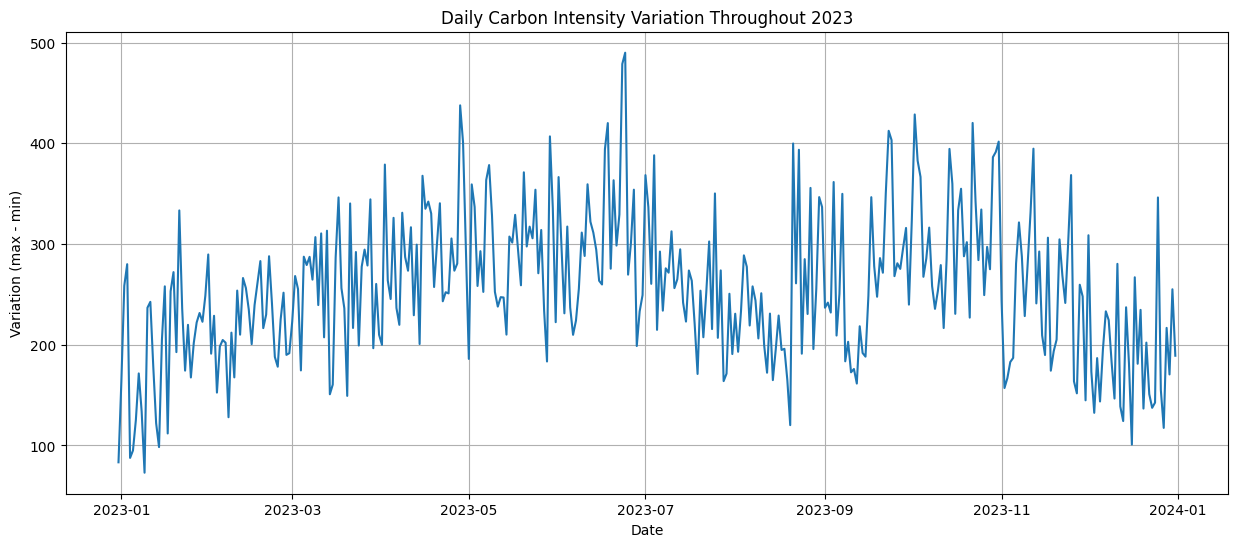

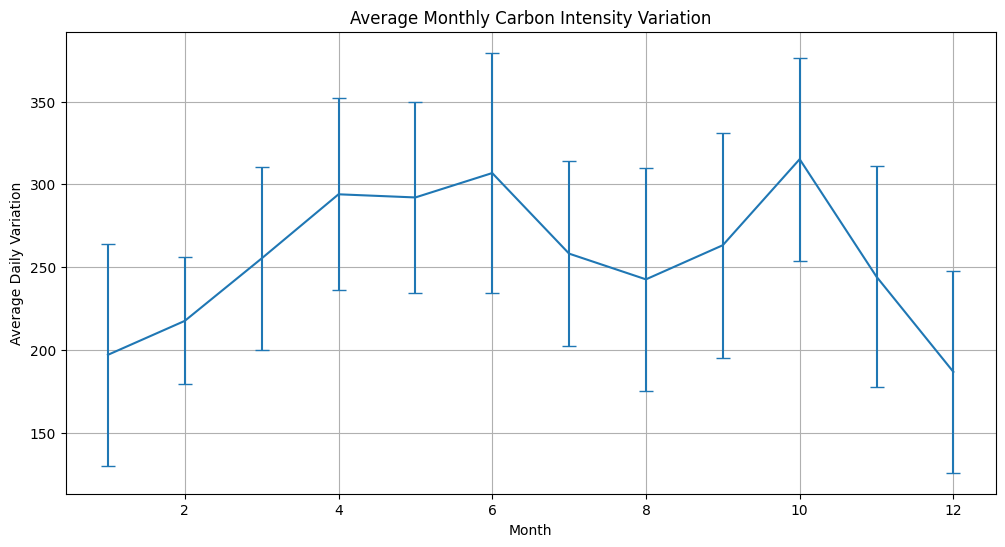


Top 10 Days with Highest Carbon Intensity Variation:
               min     max  variation
date                                 
2023-06-24  342.23  832.20     489.97
2023-06-23  329.47  808.28     478.81
2023-04-28  325.58  763.29     437.71
2023-10-02  411.59  840.25     428.66
2023-10-22  505.53  925.76     420.23
2023-06-18  281.97  702.06     420.09
2023-09-23  377.27  789.71     412.44
2023-05-29  366.15  773.05     406.90
2023-09-24  426.56  829.74     403.18
2023-10-31  450.69  852.37     401.68


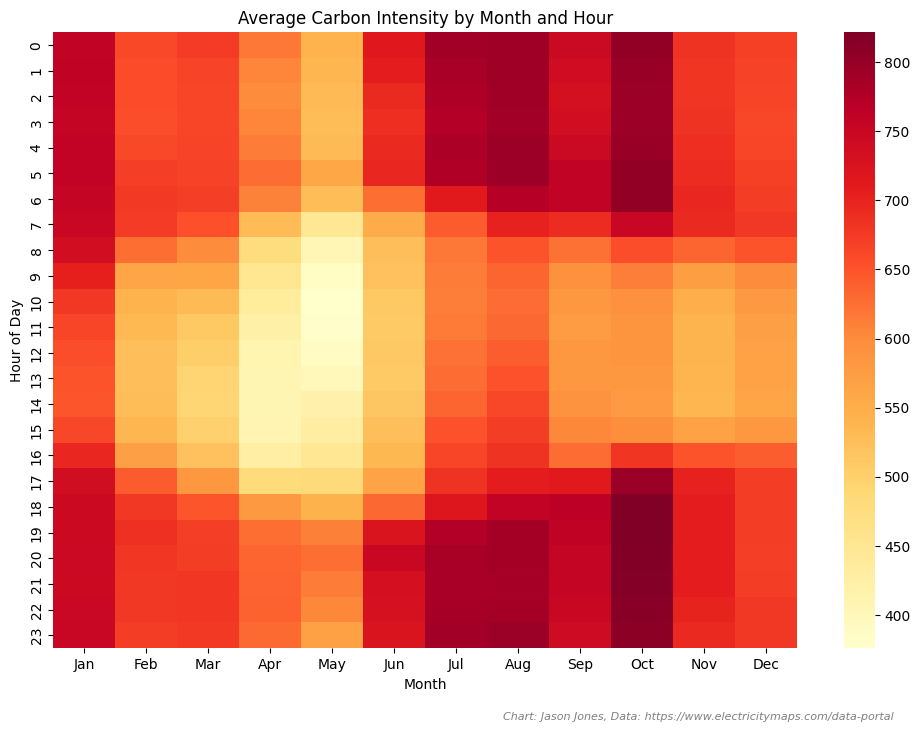

In [202]:

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['Datetime (UTC)'])
# Update hour column to use MST
df['timestamp_mst'] = df['timestamp'] - pd.Timedelta(hours=7)


# Add columns for date, month, and hour
df['date'] = df['timestamp_mst'].dt.date
df['month'] = df['timestamp_mst'].dt.month
df['hour'] = df['timestamp_mst'].dt.hour

# Calculate daily variation (max - min) for each date
daily_variation = df.groupby('date')['Carbon Intensity gCO₂eq/kWh (LCA)'].agg(['min', 'max'])
daily_variation['variation'] = daily_variation['max'] - daily_variation['min']

# Calculate monthly variation statistics
monthly_variation = df.groupby(['month', 'date'])['Carbon Intensity gCO₂eq/kWh (LCA)'].agg(['min', 'max'])
monthly_variation['variation'] = monthly_variation['max'] - monthly_variation['min']
monthly_stats = monthly_variation.groupby('month')['variation'].agg(['mean', 'std'])

# Plot daily variations throughout the year
plt.figure(figsize=(15, 6))
plt.plot(daily_variation.index, daily_variation['variation'])
plt.title('Daily Carbon Intensity Variation Throughout 2023')
plt.xlabel('Date')
plt.ylabel('Variation (max - min)')
plt.grid(True)
plt.show()

# Plot monthly average variations with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(monthly_stats.index, monthly_stats['mean'], 
             yerr=monthly_stats['std'], capsize=5)
plt.title('Average Monthly Carbon Intensity Variation')
plt.xlabel('Month')
plt.ylabel('Average Daily Variation')
plt.grid(True)
plt.show()

# Find the top 10 days with highest variation
print("\nTop 10 Days with Highest Carbon Intensity Variation:")
print(daily_variation.sort_values('variation', ascending=False).head(10))

# Create a heatmap of average carbon intensity by month and hour
hourly_monthly_avg = df.pivot_table(
    values='Carbon Intensity gCO₂eq/kWh (LCA)', 
    index='hour',
    columns='month',
    aggfunc='mean'
)

plt.figure(figsize=(12, 8))
sns.heatmap(hourly_monthly_avg, cmap='YlOrRd', 
            xticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Average Carbon Intensity by Month and Hour')
plt.xlabel('Month')
plt.ylabel('Hour of Day')
# Add source text at the bottom
plt.figtext(0.5, 0.02, 'Chart: Jason Jones, Data: https://www.electricitymaps.com/data-portal', 
           fontsize=8, style='italic', color='gray')
plt.show()

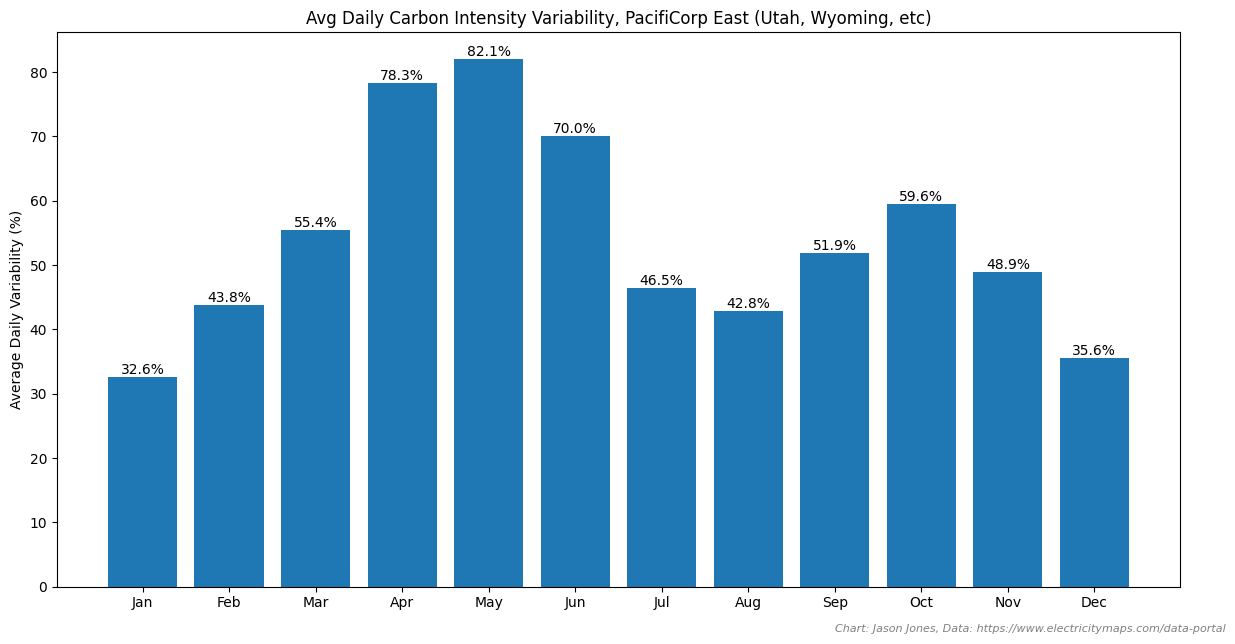


Monthly average percentage increases:
Month 1: 32.6%
Month 2: 43.8%
Month 3: 55.4%
Month 4: 78.3%
Month 5: 82.1%
Month 6: 70.0%
Month 7: 46.5%
Month 8: 42.8%
Month 9: 51.9%
Month 10: 59.6%
Month 11: 48.9%
Month 12: 35.6%


In [203]:
# Calculate percentage increase from min to max for each day
daily_variation['percent_increase'] = ((daily_variation['max'] - daily_variation['min']) / daily_variation['min']) * 100
month_names = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 
    5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
    9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

# Add month information to daily_variation
daily_variation = daily_variation.reset_index()
daily_variation['month'] = pd.to_datetime(daily_variation['date']).dt.month

# Calculate monthly average percentage increase
monthly_avg_increase = daily_variation.groupby('month')['percent_increase'].mean()

# Plot monthly average percentage increases
plt.figure(figsize=(12, 6.5))
plt.bar([month_names[m] for m in monthly_avg_increase.index], monthly_avg_increase.values)
plt.title('Avg Daily Carbon Intensity Variability, PacifiCorp East (Utah, Wyoming, etc)')
plt.xlabel(' ', x=.45)
plt.ylabel('Average Daily Variability (%)')

# plt.grid(True, axis='y')

# Add value labels on top of each bar
for i, (month, v) in enumerate(zip([month_names[m] for m in monthly_avg_increase.index], monthly_avg_increase.values)):
    plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom')

# Add source text at the bottom
plt.figtext(0.7, 0.02, 'Chart: Jason Jones, Data: https://www.electricitymaps.com/data-portal', 
           fontsize=8, style='italic', color='gray')

plt.tight_layout()

plt.show()

# Print the values
print("\nMonthly average percentage increases:")
for month, value in monthly_avg_increase.items():
    print(f"Month {month}: {value:.1f}%")

In [209]:
# Convert timestamp to datetime and set as index
df['timestamp'] = pd.to_datetime(df['timestamp_mst'])
df = df.set_index('timestamp')

# Calculate daily variability
daily_stats = df.resample('D')['Carbon Intensity gCO₂eq/kWh (LCA)'].agg(['min', 'max'])
daily_stats['variability'] = (daily_stats['max'] - daily_stats['min']) / daily_stats['min'] * 100  # as percentage

# Find the day with highest variability
max_var_day = daily_stats['variability'].idxmax()
max_var_stats = daily_stats.loc[max_var_day]

print(f"\nDay with Highest Variability: {max_var_day.strftime('%B %d, %Y')}")
print("-" * 50)
print(f"Minimum: {max_var_stats['min']:.1f} gCO₂eq/kWh")
print(f"Maximum: {max_var_stats['max']:.1f} gCO₂eq/kWh")
print(f"Variability: {max_var_stats['variability']:.1f}%")

# Show top 5 most variable days
print("\nTop 5 Most Variable Days:")
print("-" * 50)
top_5_days = daily_stats.nlargest(5, 'variability')
for date, stats in top_5_days.iterrows():
    print(f"{date.strftime('%B %d, %Y')}:")
    print(f"  Min: {stats['min']:.1f} gCO₂eq/kWh")
    print(f"  Max: {stats['max']:.1f} gCO₂eq/kWh")
    print(f"  Variability: {stats['variability']:.1f}%")


Day with Highest Variability: June 18, 2023
--------------------------------------------------
Minimum: 282.0 gCO₂eq/kWh
Maximum: 702.1 gCO₂eq/kWh
Variability: 149.0%

Top 5 Most Variable Days:
--------------------------------------------------
June 18, 2023:
  Min: 282.0 gCO₂eq/kWh
  Max: 702.1 gCO₂eq/kWh
  Variability: 149.0%
June 23, 2023:
  Min: 329.5 gCO₂eq/kWh
  Max: 808.3 gCO₂eq/kWh
  Variability: 145.3%
June 24, 2023:
  Min: 342.2 gCO₂eq/kWh
  Max: 832.2 gCO₂eq/kWh
  Variability: 143.2%
April 28, 2023:
  Min: 325.6 gCO₂eq/kWh
  Max: 763.3 gCO₂eq/kWh
  Variability: 134.4%
May 07, 2023:
  Min: 279.6 gCO₂eq/kWh
  Max: 643.1 gCO₂eq/kWh
  Variability: 130.0%


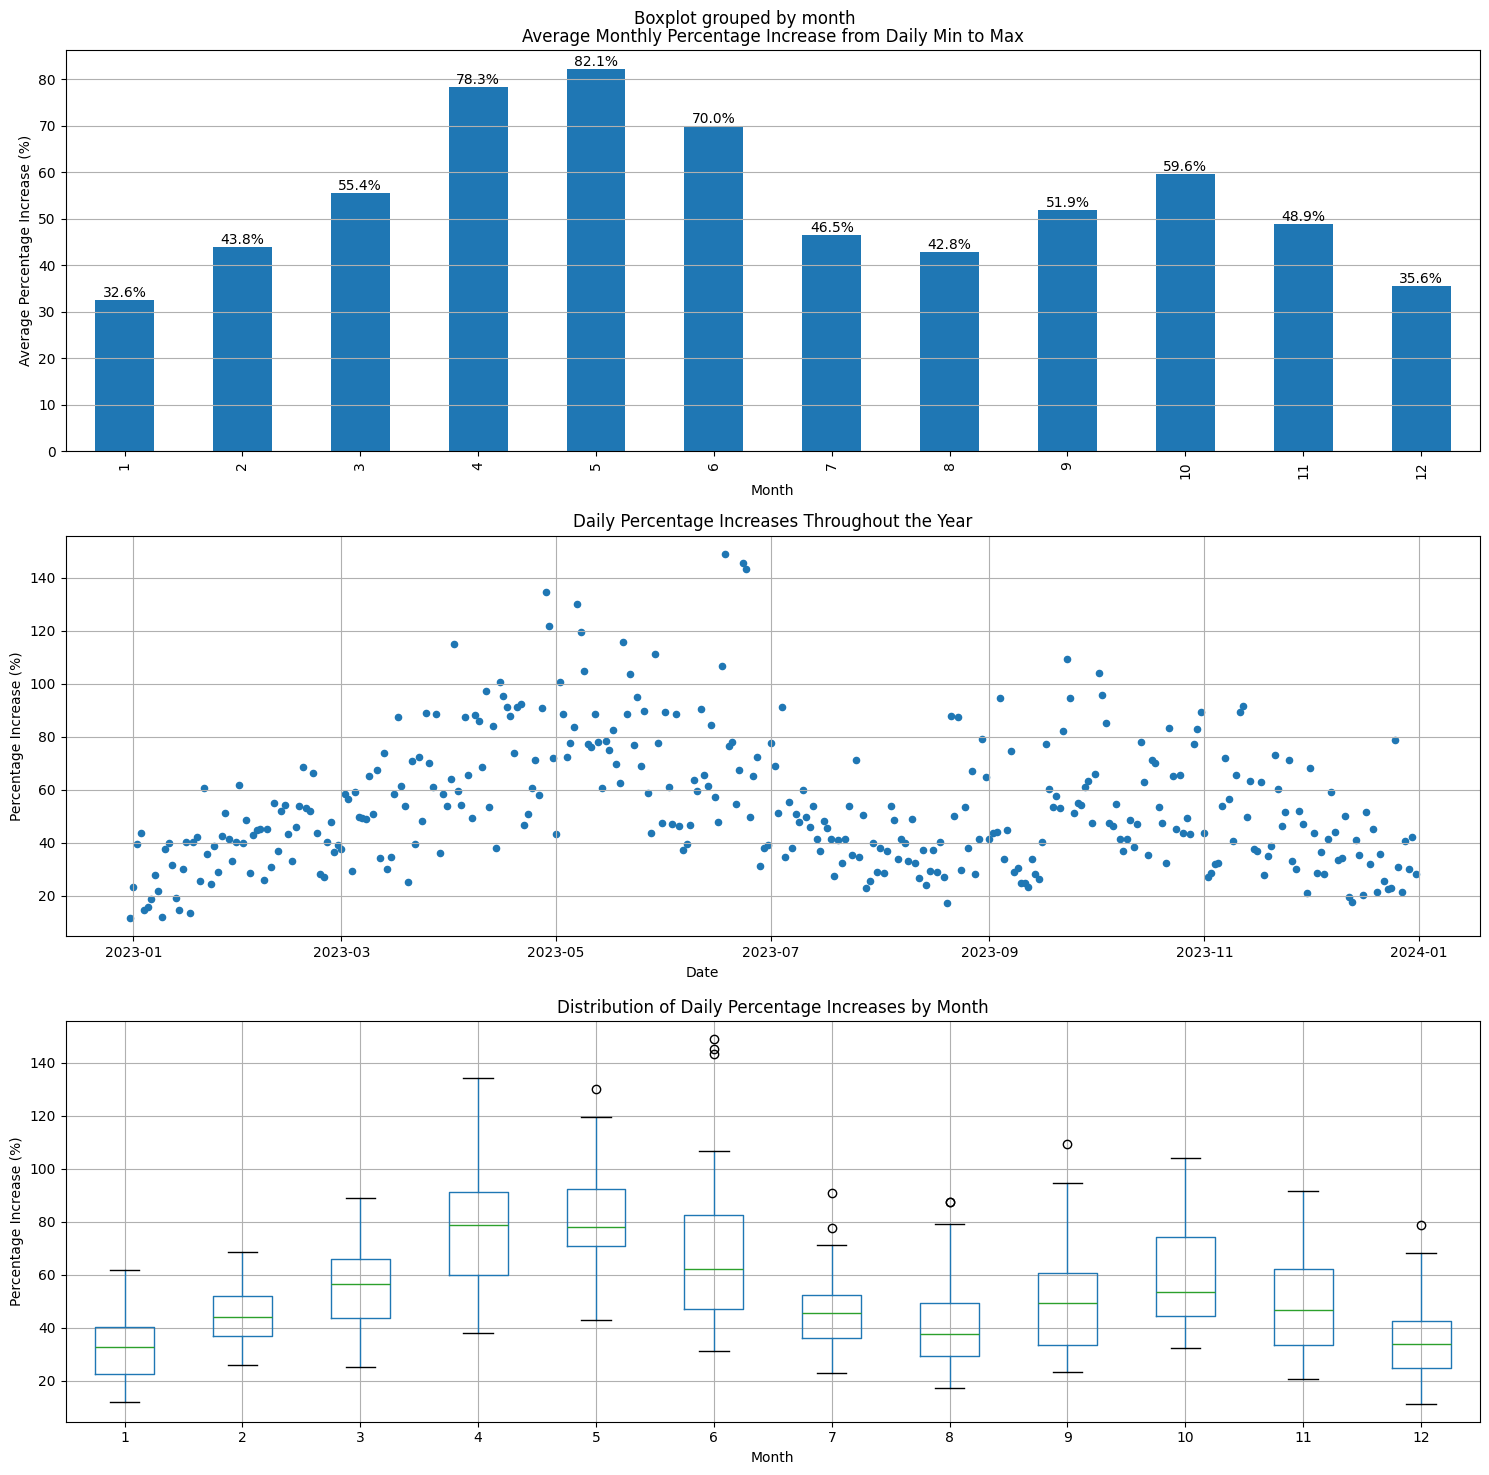


Summary Statistics of Daily Variations:
count    366.000000
mean      53.889216
std       24.601800
min       11.416189
25%       36.767165
50%       48.604516
75%       68.366292
max      148.983934
Name: percent_increase, dtype: float64


In [204]:
# Create a figure with multiple subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

# 1. Monthly averages (bar chart) - keeping your existing visualization
monthly_avg_increase.plot(kind='bar', ax=ax1)
ax1.set_title('Average Monthly Percentage Increase from Daily Min to Max')
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Percentage Increase (%)')
ax1.grid(True, axis='y')
for i, v in enumerate(monthly_avg_increase.values):
    ax1.text(i, v, f'{v:.1f}%', ha='center', va='bottom')

# 2. Daily variations throughout the year (scatter plot)
daily_variation.plot(x='date', y='percent_increase', kind='scatter', ax=ax2)
ax2.set_title('Daily Percentage Increases Throughout the Year')
ax2.set_xlabel('Date', x=.45)
ax2.set_ylabel('Percentage Increase (%)')
ax2.grid(True)

# 3. Box plot to show distribution by month
daily_variation.boxplot(column='percent_increase', by='month', ax=ax3)
ax3.set_title('Distribution of Daily Percentage Increases by Month')
ax3.set_xlabel('Month')
ax3.set_ylabel('Percentage Increase (%)')
ax3.grid(True)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics of Daily Variations:")
print(daily_variation['percent_increase'].describe())

In [205]:
# Filter for May
may_variations = daily_variation[daily_variation['month'] == 5].copy()

# Sort by date
may_variations = may_variations.sort_values('date')

# Create formatted output
print("May 2023 Daily Carbon Intensity Variations:")
print("\nDate         Min     Max     % Increase")
print("-" * 45)
for _, row in may_variations.iterrows():
    print(f"{row['date'].strftime('%Y-%m-%d')}  {row['min']:6.1f}  {row['max']:6.1f}  {row['percent_increase']:8.1f}%")

# Print summary statistics for May
print("\nMay Summary:")
print(f"Average daily increase: {may_variations['percent_increase'].mean():.1f}%")
print(f"Highest daily increase: {may_variations['percent_increase'].max():.1f}%")
print(f"Lowest daily increase:  {may_variations['percent_increase'].min():.1f}%")

May 2023 Daily Carbon Intensity Variations:

Date         Min     Max     % Increase
---------------------------------------------
2023-05-01   431.8   617.8      43.1%
2023-05-02   357.8   717.0     100.4%
2023-05-03   381.2   718.1      88.4%
2023-05-04   357.5   615.9      72.3%
2023-05-05   378.2   671.1      77.5%
2023-05-06   301.9   554.4      83.6%
2023-05-07   279.6   643.1     130.0%
2023-05-08   316.3   694.7     119.6%
2023-05-09   314.0   642.3     104.6%
2023-05-10   326.7   579.2      77.3%
2023-05-11   312.1   549.9      76.2%
2023-05-12   279.0   526.2      88.6%
2023-05-13   316.7   563.6      78.0%
2023-05-14   347.5   557.6      60.4%
2023-05-15   392.3   699.7      78.4%
2023-05-16   402.0   703.4      75.0%
2023-05-17   399.1   728.1      82.4%
2023-05-18   422.8   717.0      69.6%
2023-05-19   414.2   673.2      62.5%
2023-05-20   320.8   692.0     115.7%
2023-05-21   336.7   634.3      88.4%
2023-05-22   306.5   623.8     103.5%
2023-05-23   398.2   704.0      7

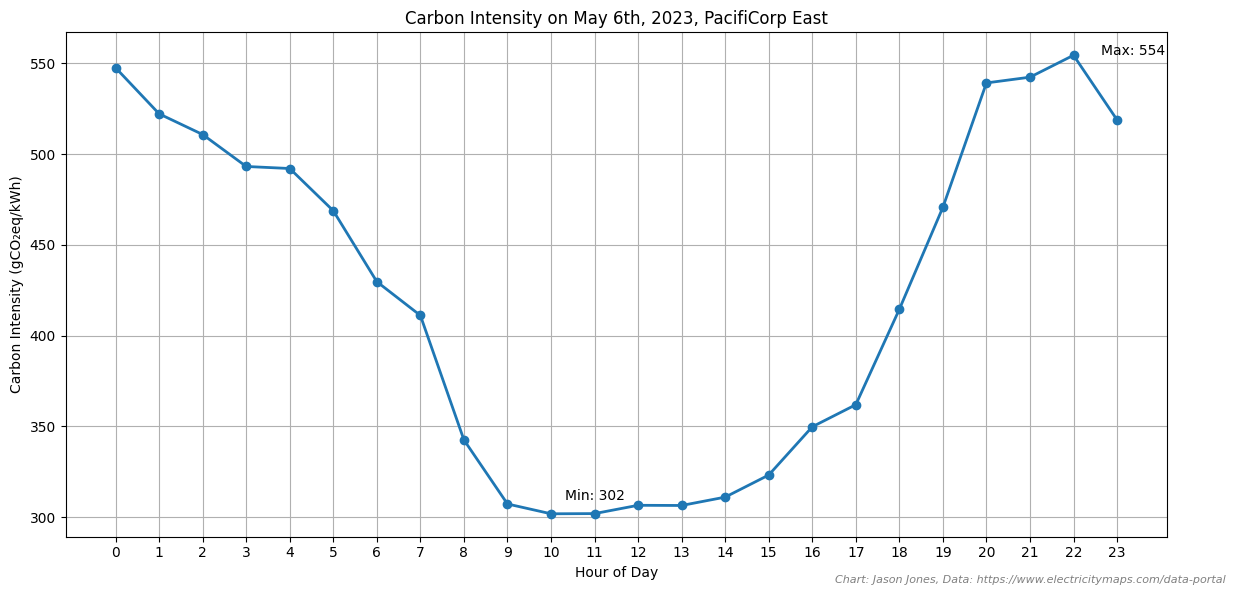


Minimum: 302 at hour 10
Maximum: 554 at hour 22
Increase: 83.6%


In [164]:
# Filter for top variable day
top_variable_day = daily_stats.nlargest(1, 'variability')
# Sort by timestamp to ensure proper ordering
top_variable_day = top_variable_day.sort_values('timestamp_mst')

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(top_variable_day['timestamp_mst'].dt.hour, top_variable_day['Carbon Intensity gCO₂eq/kWh (LCA)'], 
         marker='o', linestyle='-', linewidth=2)

# Customize the plot
plt.title('Carbon Intensity on May 6th, 2023, PacifiCorp East')
plt.xlabel('Hour of Day')  # Moved x-axis label to the left
plt.ylabel('Carbon Intensity (gCO₂eq/kWh)')
plt.grid(True)
plt.xticks(range(0, 24))

# Add min and max annotations
min_value = top_variable_day['Carbon Intensity gCO₂eq/kWh (LCA)'].min()
max_value = top_variable_day['Carbon Intensity gCO₂eq/kWh (LCA)'].max()
min_hour = top_variable_day.loc[top_variable_day['Carbon Intensity gCO₂eq/kWh (LCA)'].idxmin(), 'timestamp_mst'].hour
max_hour = top_variable_day.loc[top_variable_day['Carbon Intensity gCO₂eq/kWh (LCA)'].idxmax(), 'timestamp_mst'].hour

plt.annotate(f'Min: {min_value:.0f}', 
            xy=(min_hour, min_value), 
            xytext=(10, 10), 
            textcoords='offset points')
plt.annotate(f'Max: {max_value:.0f}', 
            xy=(max_hour, max_value), 
            xytext=(20, 0), 
            textcoords='offset points')

# Add source text at the bottom
plt.figtext(0.7, 0.02, 'Chart: Jason Jones, Data: https://www.electricitymaps.com/data-portal', 
           fontsize=8, style='italic', color='gray')

plt.tight_layout()

plt.show()

# Print summary statistics
print(f"\nMinimum: {min_value:.0f} at hour {min_hour}")
print(f"Maximum: {max_value:.0f} at hour {max_hour}")
print(f"Increase: {((max_value - min_value) / min_value * 100):.1f}%")

highest_start_hour: 20
highest_end_hour: 22


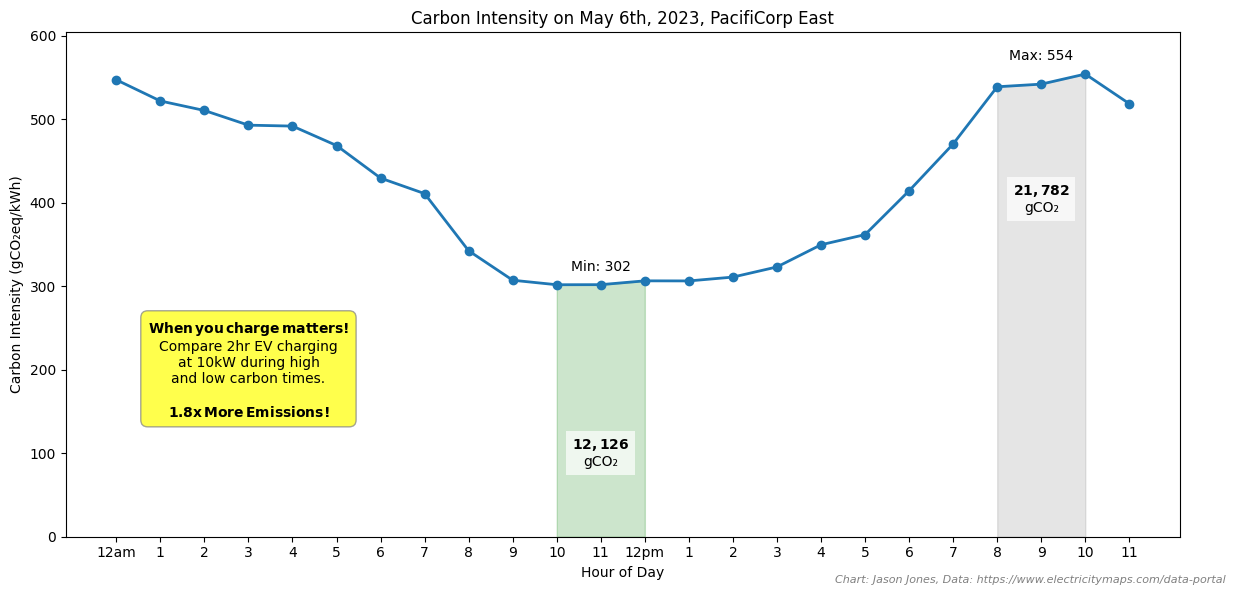


Minimum: 301.9 at hour 10
Maximum: 554.4 at hour 22
Increase: 83.6%

Area under curve 3-5am: 1089.1 gCO₂eq/kWh·hour
Area under curve 4-6pm: 606.3 gCO₂eq/kWh·hour


In [198]:
# Filter for May 6th
may_6_data = df[df['timestamp_mst'].dt.date == pd.to_datetime('2023-05-06').date()].copy()

# Sort by timestamp to ensure proper ordering
may_6_data = may_6_data.sort_values('timestamp_mst')
# Calculate rolling 2-hour averages
rolling_2h = may_6_data['Carbon Intensity gCO₂eq/kWh (LCA)'].rolling(window=2).mean()

# Find the lowest and highest 2-hour periods
lowest_idx = rolling_2h.idxmin()
highest_idx = rolling_2h.idxmax()

# Get the start times and values
lowest_start = may_6_data.loc[lowest_idx]['timestamp_mst']
highest_start = may_6_data.loc[highest_idx]['timestamp_mst']
# Get the start hours for both periods
lowest_start_hour = lowest_start.hour -1
lowest_end_hour = lowest_start_hour + 2

# HACK to avoid overnight high carbon time
highest_start_hour = 20
highest_end_hour = highest_start_hour + 2

print(f'highest_start_hour: {highest_start_hour}')  # Using f-string
print(f'highest_end_hour: {highest_end_hour}')
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(may_6_data['timestamp_mst'].dt.hour, may_6_data['Carbon Intensity gCO₂eq/kWh (LCA)'], 
         marker='o', linestyle='-', linewidth=2)

# Create list of hour labels with AM/PM only at 12am and 12pm
hour_labels = []
for h in range(24):
    if h == 0:
        hour_labels.append('12am')
    elif h == 12:
        hour_labels.append('12pm')
    else:
        hour_labels.append(f'{h%12 or 12}')
# Set the x-ticks and labels
plt.xticks(range(24), hour_labels)


# Add shaded regions below the curve
# For high carbon time (gray)
mask_high = (may_6_data['timestamp_mst'].dt.hour >= highest_start_hour) & (may_6_data['timestamp_mst'].dt.hour <= highest_end_hour)
plt.fill_between(may_6_data[mask_high]['timestamp_mst'].dt.hour, 
                0, 
                may_6_data[mask_high]['Carbon Intensity gCO₂eq/kWh (LCA)'],
                color='gray', alpha=0.2)

# Calculate area for high carbon
area_high = np.trapezoid(may_6_data[mask_high]['Carbon Intensity gCO₂eq/kWh (LCA)'], 
                    may_6_data[mask_high]['timestamp_mst'].dt.hour)


# For low carbon time (green)
mask_low = (may_6_data['timestamp_mst'].dt.hour >= lowest_start_hour) & (may_6_data['timestamp_mst'].dt.hour <= lowest_end_hour)
plt.fill_between(may_6_data[mask_low]['timestamp_mst'].dt.hour, 
                0, 
                may_6_data[mask_low]['Carbon Intensity gCO₂eq/kWh (LCA)'],
                color='green', alpha=0.2)

# Calculate area for low carbon
area_low = np.trapezoid(may_6_data[mask_low]['Carbon Intensity gCO₂eq/kWh (LCA)'], 
                      may_6_data[mask_low]['timestamp_mst'].dt.hour)




low_carbon_data = may_6_data[mask_low]['Carbon Intensity gCO₂eq/kWh (LCA)']
high_carbon_data = may_6_data[mask_high]['Carbon Intensity gCO₂eq/kWh (LCA)']
# Add label at the top of the green shaded area
low_carbon_x = lowest_start_hour + 1  # Center of the window
low_carbon_y = low_carbon_data.min() + 20  # Slightly above the shaded area

# Add label at the top of the green shaded area
high_carbon_x = highest_start_hour + 1  # Center of the window
high_carbon_y = high_carbon_data.max() - 150  # high end of the shaded area

# Add label for low carbon time
plt.text(low_carbon_x, 100, 
         f'$\\mathbf{{{20 * area_low:,.0f}}}$\ngCO₂', 
         ha='center', va='center',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
# Add label for high carbon time
plt.text(high_carbon_x, high_carbon_y, 
         f'$\\mathbf{{{20 * area_high:,.0f}}}$\ngCO₂', 
         ha='center', va='center', 
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.text(3, 200, 
         r'$\mathbf{When\,you\,charge\,matters!}$' + 
         '\nCompare 2hr EV charging\nat 10kW during high\nand low carbon times.\n\n' +
         fr'$\mathbf{{{area_high/area_low:.1f}x\,More\,Emissions!}}$',
         ha='center', va='center',
         bbox=dict(facecolor='yellow', alpha=0.7, edgecolor='gray', boxstyle='round,pad=0.5'))


# Customize the plot
plt.title('Carbon Intensity on May 6th, 2023, PacifiCorp East')
plt.xlabel('Hour of Day')  # Moved x-axis label to the left
plt.ylabel('Carbon Intensity (gCO₂eq/kWh)')
# plt.grid(True)
plt.xticks(range(0, 24))

# Add min and max annotations
min_value = may_6_data['Carbon Intensity gCO₂eq/kWh (LCA)'].min()
max_value = may_6_data['Carbon Intensity gCO₂eq/kWh (LCA)'].max()
min_hour = may_6_data.loc[may_6_data['Carbon Intensity gCO₂eq/kWh (LCA)'].idxmin(), 'timestamp_mst'].hour
max_hour = may_6_data.loc[may_6_data['Carbon Intensity gCO₂eq/kWh (LCA)'].idxmax(), 'timestamp_mst'].hour

plt.ylim(0, max_value + 50)
plt.annotate(f'Min: {min_value:.0f}', 
            xy=(min_hour, min_value), 
            xytext=(10, 10), 
            textcoords='offset points')
plt.annotate(f'Max: {max_value:.0f}', 
            xy=(max_hour, max_value), 
            xytext=(-55, 10), 
            textcoords='offset points')

# Add source text at the bottom
plt.figtext(0.7, 0.02, 'Chart: Jason Jones, Data: https://www.electricitymaps.com/data-portal', 
           fontsize=8, style='italic', color='gray')

plt.tight_layout()

plt.show()

# Print summary statistics
print(f"\nMinimum: {min_value:.1f} at hour {min_hour}")
print(f"Maximum: {max_value:.1f} at hour {max_hour}")
print(f"Increase: {((max_value - min_value) / min_value * 100):.1f}%")

# Print the areas
print(f"\nArea under curve 3-5am: {area_high:.1f} gCO₂eq/kWh·hour")
print(f"Area under curve 4-6pm: {area_low:.1f} gCO₂eq/kWh·hour")

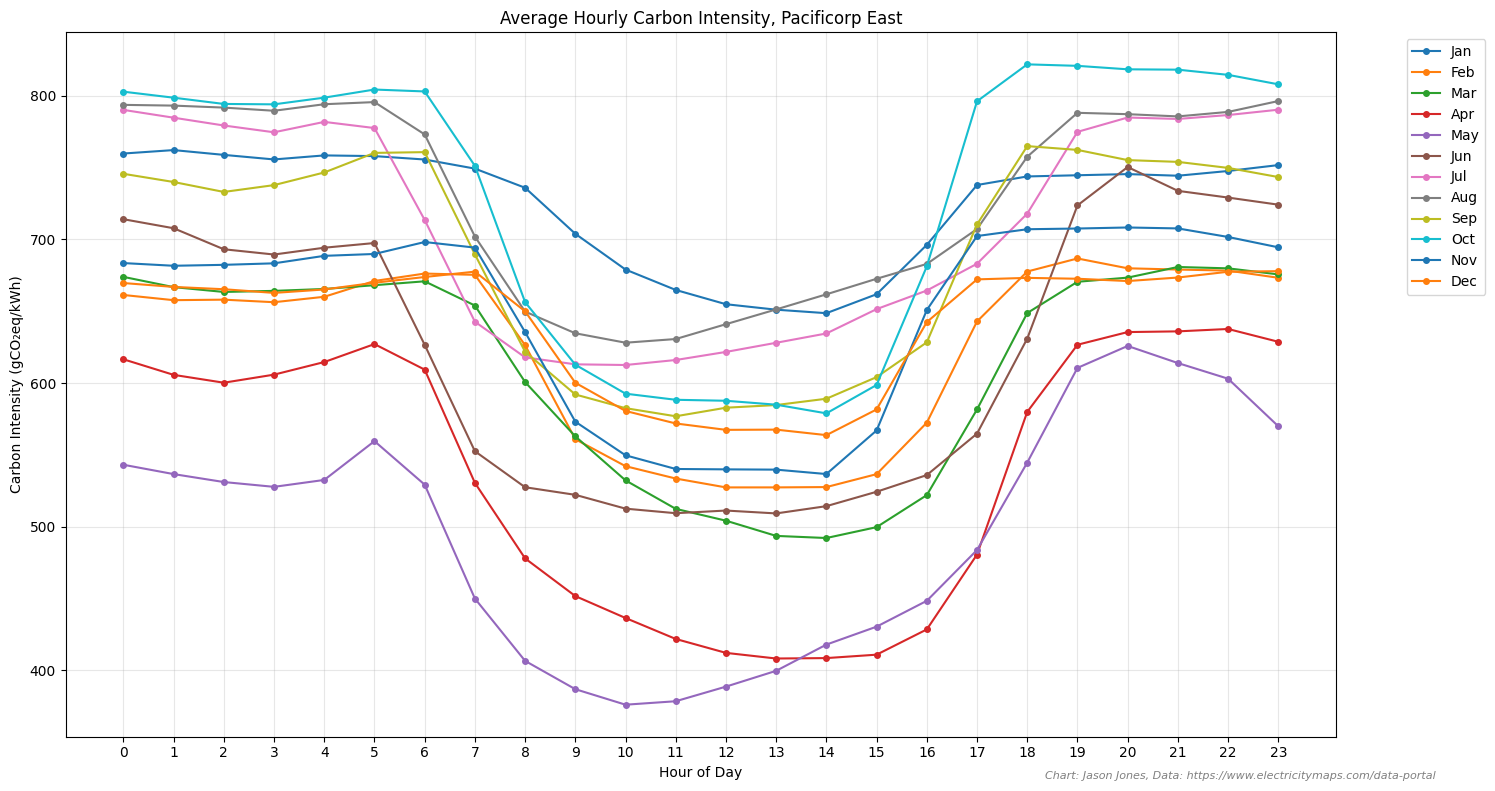


Hourly averages by month:
hour      0      1      2      3      4      5      6      7      8      9   \
month                                                                         
Jan    759.8  762.2  758.9  755.7  758.5  758.1  755.7  749.3  736.0  703.9   
Feb    661.3  657.7  658.1  656.3  660.1  671.1  676.2  675.4  626.4  560.9   
Mar    673.9  666.8  663.4  664.2  665.5  668.1  670.8  654.0  600.7  562.8   
Apr    616.5  605.7  600.2  605.8  614.6  627.1  609.3  530.4  477.8  451.6   
May    543.1  536.6  531.0  527.7  532.5  559.5  529.2  449.9  406.5  386.7   
Jun    714.1  707.8  693.2  689.5  694.2  697.5  626.6  552.5  527.4  522.1   
Jul    790.2  784.8  779.4  774.6  781.9  777.6  713.6  642.7  617.9  613.0   
Aug    793.7  793.2  791.8  789.6  794.2  795.7  773.2  702.0  649.8  634.6   
Sep    745.7  740.0  733.1  737.9  746.7  760.3  760.8  689.6  621.8  592.0   
Oct    802.9  798.7  794.4  794.1  798.8  804.4  803.1  751.3  656.3  612.7   
Nov    683.5  681.7  682.

In [190]:
# Create a month number to name mapping
month_names = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 
    5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
    9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

# Calculate hourly averages for each month
hourly_by_month = df.groupby(['month', 'hour'])['Carbon Intensity gCO₂eq/kWh (LCA)'].mean().unstack()

# Create the plot
plt.figure(figsize=(15, 8))

# Plot a line for each month
for month in hourly_by_month.index:
    plt.plot(hourly_by_month.columns, 
            hourly_by_month.loc[month], 
            label=month_names[month],
            marker='o',
            markersize=4)

plt.title('Average Hourly Carbon Intensity, Pacificorp East')
plt.xlabel('Hour of Day')
plt.ylabel('Carbon Intensity (gCO₂eq/kWh)')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# Add source text at the bottom
plt.figtext(0.7, 0.02, 'Chart: Jason Jones, Data: https://www.electricitymaps.com/data-portal', 
           fontsize=8, style='italic', color='gray')

plt.tight_layout()

# Set x-axis ticks to show all 24 hours
plt.xticks(range(24))

plt.show()

# Rename the index for the printed table
hourly_by_month.index = hourly_by_month.index.map(month_names)
print("\nHourly averages by month:")
print(hourly_by_month.round(1))

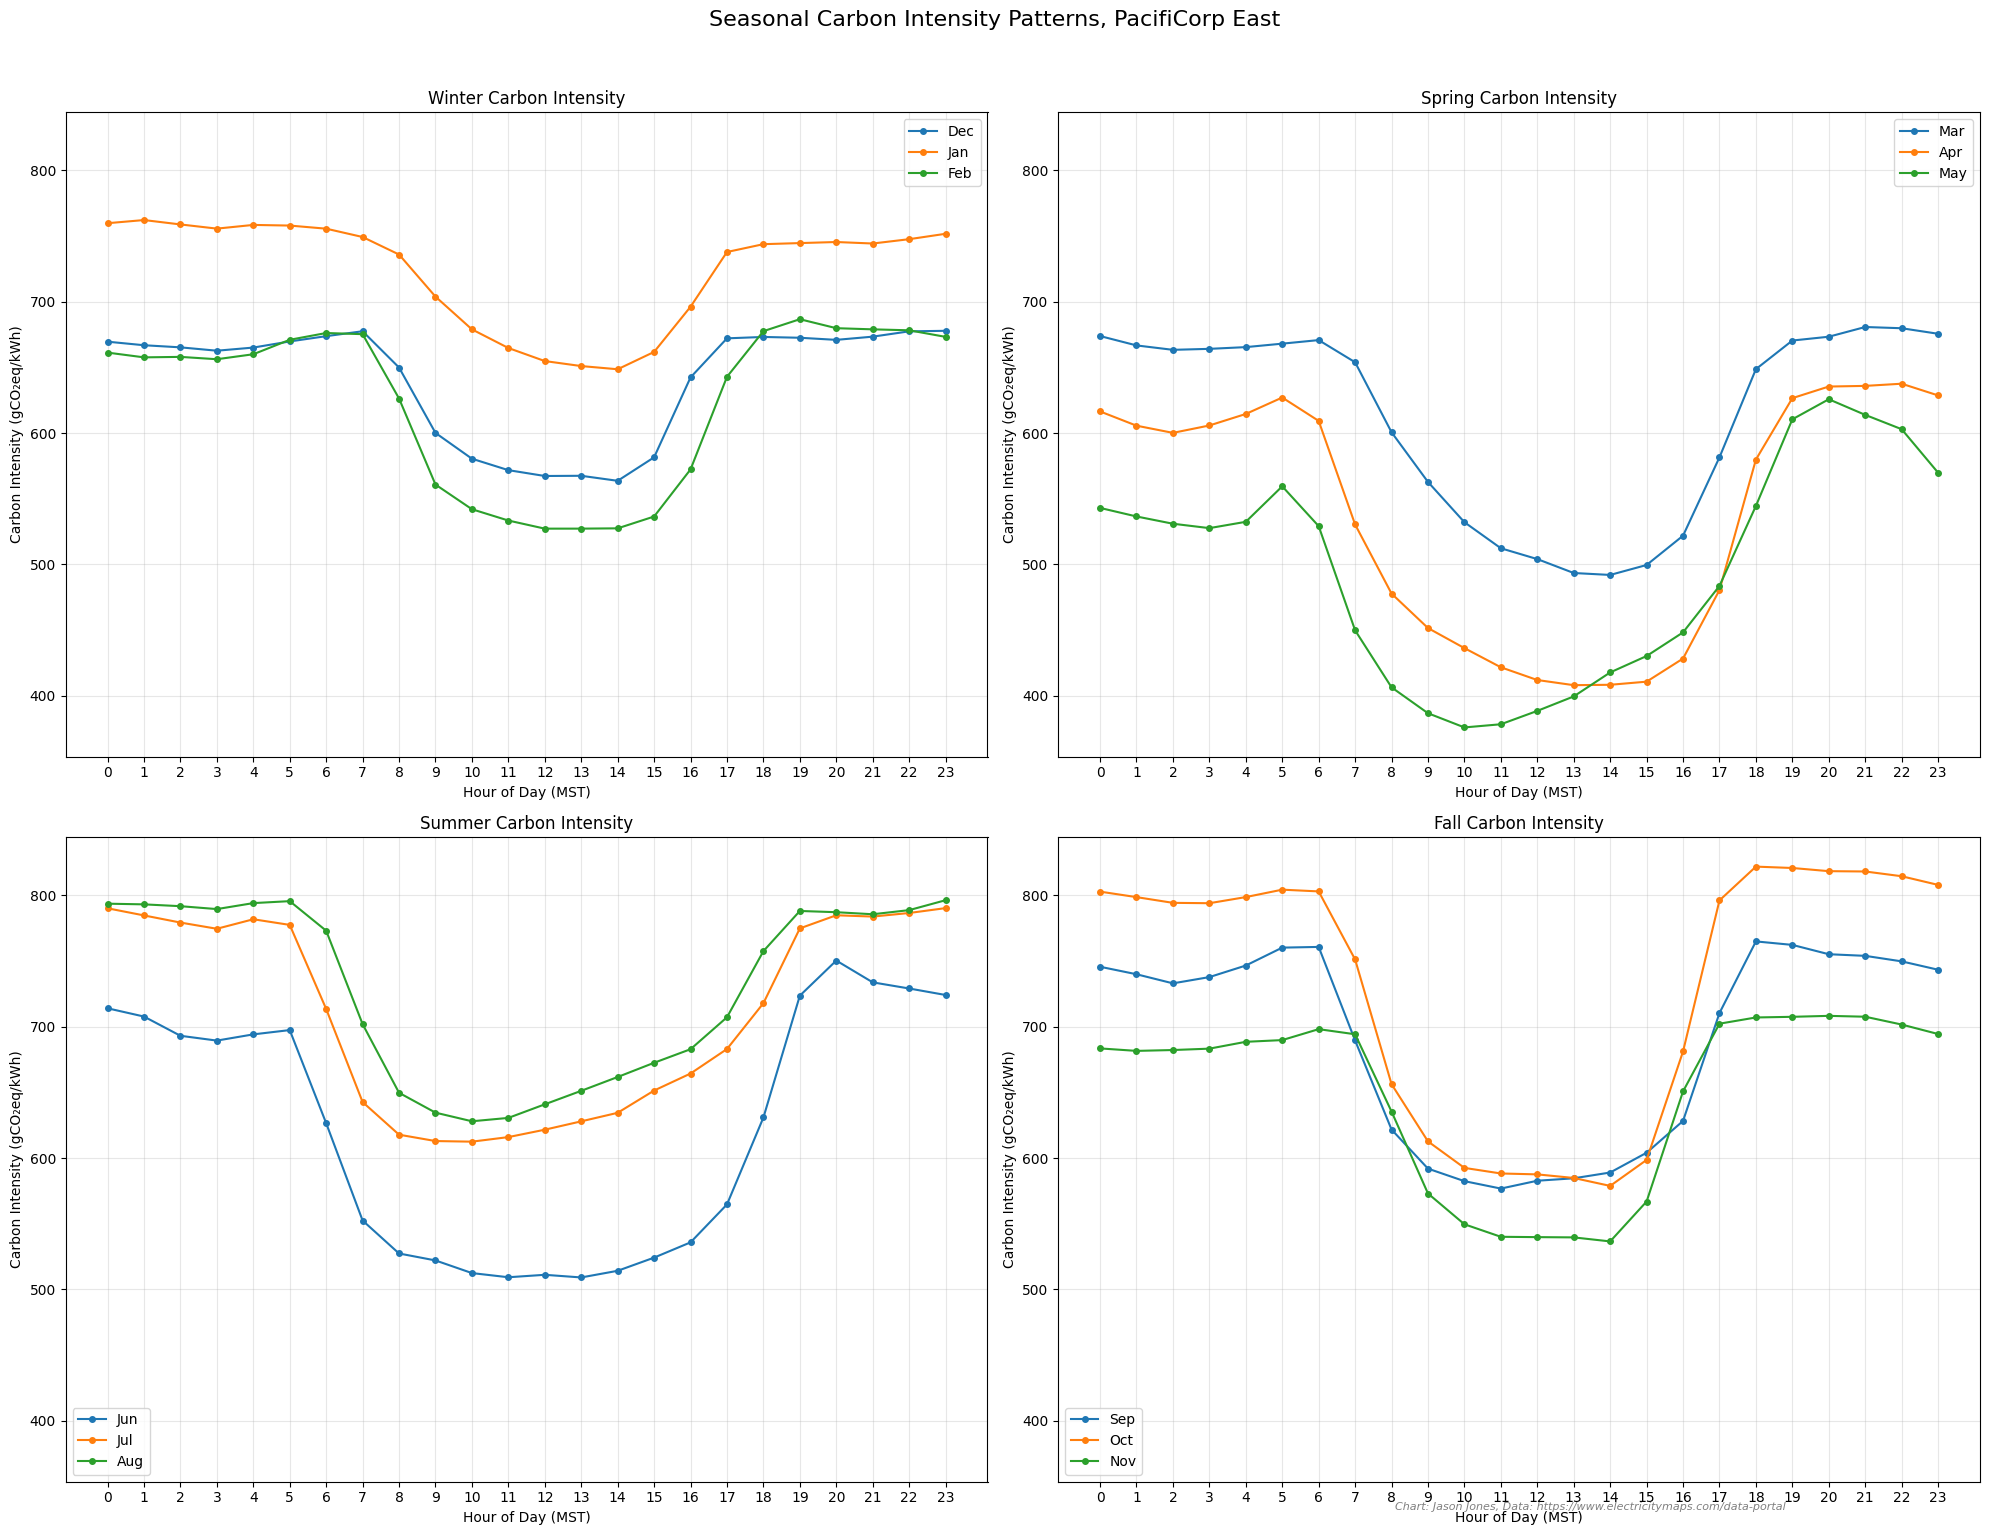


Seasonal hourly averages:

Winter:
hour
0     696.9
1     695.6
2     694.1
3     691.6
4     694.6
5     699.7
6     701.9
7     700.8
8     670.8
9     621.7
10    600.5
11    590.0
12    583.2
13    582.0
14    580.0
15    593.3
16    637.0
17    684.3
18    698.3
19    701.4
20    698.8
21    699.0
22    701.2
23    701.0
dtype: float64

Spring:
hour
0     611.2
1     603.0
2     598.2
3     599.2
4     604.2
5     618.3
6     603.1
7     544.8
8     495.0
9     467.1
10    448.1
11    437.5
12    434.9
13    433.7
14    439.4
15    446.9
16    466.2
17    515.3
18    591.1
19    635.9
20    644.9
21    643.6
22    640.2
23    624.8
dtype: float64

Summer:
hour
0     766.0
1     761.9
2     754.8
3     751.3
4     756.8
5     756.9
6     704.5
7     632.4
8     598.3
9     589.9
10    584.4
11    585.3
12    591.3
13    596.1
14    603.5
15    616.1
16    627.7
17    651.7
18    702.2
19    762.3
20    774.2
21    767.8
22    768.2
23    770.3
dtype: float64

Fall:
hour
0     744.

In [193]:
# Define seasons
seasons = {
    'Winter': [12, 1, 2],    # Dec, Jan, Feb
    'Spring': [3, 4, 5],     # Mar, Apr, May
    'Summer': [6, 7, 8],     # Jun, Jul, Aug
    'Fall': [9, 10, 11]      # Sep, Oct, Nov
}

# Find global min and max for consistent y-axis
y_min = hourly_by_month.min().min()
y_max = hourly_by_month.max().max()
# Add 5% padding to y-axis
y_padding = (y_max - y_min) * 0.05
y_min = y_min - y_padding
y_max = y_max + y_padding

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()

# Plot each season
for idx, (season, months) in enumerate(seasons.items()):
    ax = axes[idx]
    
    # Plot lines for each month in the season
    for month in months:
        ax.plot(hourly_by_month.columns, 
                hourly_by_month.loc[month_names[month]], 
                label=month_names[month],
                marker='o',
                markersize=4)
    
    # Customize each subplot
    ax.set_title(f'{season} Carbon Intensity')
    ax.set_xlabel('Hour of Day (MST)')
    ax.set_ylabel('Carbon Intensity (gCO₂eq/kWh)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.set_xticks(range(24))
    
    # Set consistent y-axis limits
    ax.set_ylim(y_min, y_max)

# Add overall title
plt.suptitle('Seasonal Carbon Intensity Patterns, PacifiCorp East', y=1.02, fontsize=16)

# Add source text
plt.figtext(0.7, 0.02, 'Chart: Jason Jones, Data: https://www.electricitymaps.com/data-portal', 
            fontsize=8, style='italic', color='gray')

plt.tight_layout()
plt.show()

# Print seasonal averages
print("\nSeasonal hourly averages:")
for season, months in seasons.items():
    seasonal_data = hourly_by_month.loc[[month_names[m] for m in months]].mean()
    print(f"\n{season}:")
    print(seasonal_data.round(1))

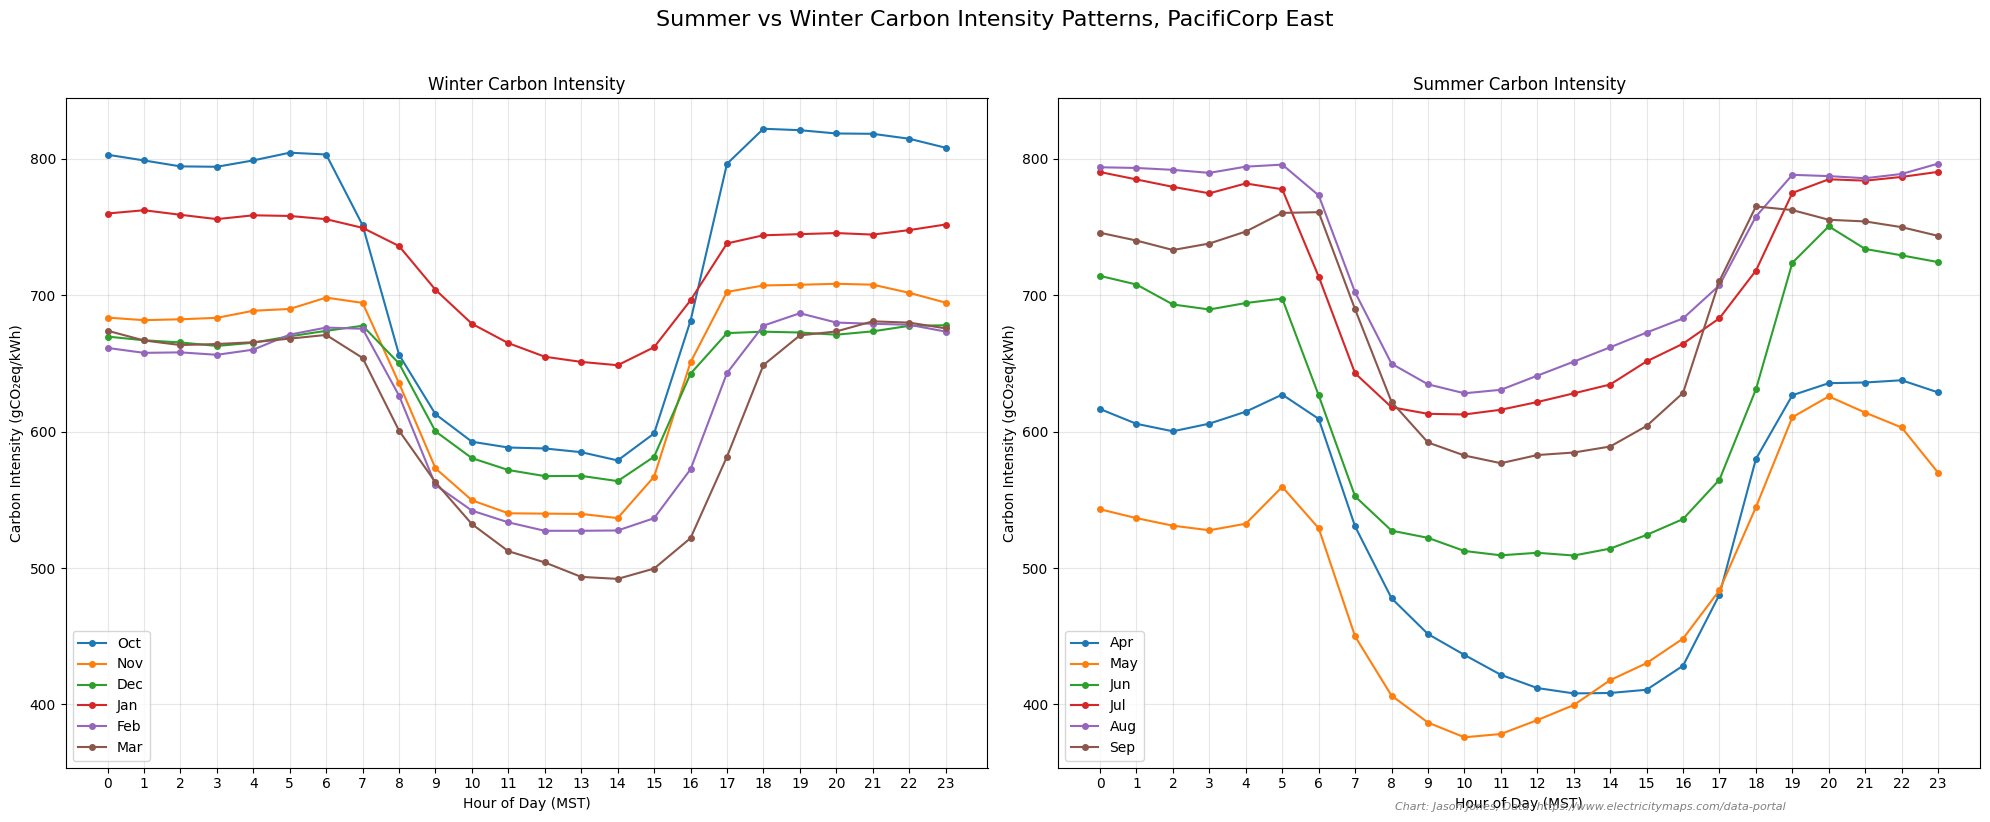


Seasonal hourly averages:

Winter:
hour
0     708.5
1     705.7
2     703.7
3     702.7
4     706.1
5     710.2
6     713.0
7     700.3
8     650.8
9     602.3
10    579.3
11    568.5
12    563.5
13    560.7
14    557.9
15    574.2
16    627.5
17    688.9
18    712.1
19    717.2
20    716.1
21    717.3
22    716.6
23    713.5
dtype: float64

Summer:
hour
0     700.6
1     694.7
2     688.1
3     687.5
4     694.0
5     703.0
6     668.8
7     594.5
8     550.2
9     533.3
10    524.6
11    522.1
12    526.2
13    530.1
14    537.6
15    548.9
16    564.7
17    605.0
18    666.0
19    714.4
20    723.2
21    717.9
22    715.9
23    708.8
dtype: float64


In [195]:
# Define seasons
seasons = {
    'Winter': [10,11,12, 1, 2, 3],    # Dec, Jan, Feb
    'Summer': [4,5,6, 7, 8,9]      # Jun, Jul, Aug
}

# Find global min and max for consistent y-axis
y_min = hourly_by_month.min().min()
y_max = hourly_by_month.max().max()
# Add 5% padding to y-axis
y_padding = (y_max - y_min) * 0.05
y_min = y_min - y_padding
y_max = y_max + y_padding

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot each season
for idx, (season, months) in enumerate(seasons.items()):
    ax = ax1 if idx == 0 else ax2
    
    # Plot lines for each month in the season
    for month in months:
        ax.plot(hourly_by_month.columns, 
                hourly_by_month.loc[month_names[month]], 
                label=month_names[month],
                marker='o',
                markersize=4)
    
    # Customize each subplot
    ax.set_title(f'{season} Carbon Intensity')
    ax.set_xlabel('Hour of Day (MST)')
    ax.set_ylabel('Carbon Intensity (gCO₂eq/kWh)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.set_xticks(range(24))
    
    # Set consistent y-axis limits
    ax.set_ylim(y_min, y_max)

# Add overall title
plt.suptitle('Summer vs Winter Carbon Intensity Patterns, PacifiCorp East', y=1.02, fontsize=16)

# Add source text
plt.figtext(0.7, 0.02, 'Chart: Jason Jones, Data: https://www.electricitymaps.com/data-portal', 
            fontsize=8, style='italic', color='gray')

plt.tight_layout()
plt.show()

# Print seasonal averages
print("\nSeasonal hourly averages:")
for season, months in seasons.items():
    seasonal_data = hourly_by_month.loc[[month_names[m] for m in months]].mean()
    print(f"\n{season}:")
    print(seasonal_data.round(1))

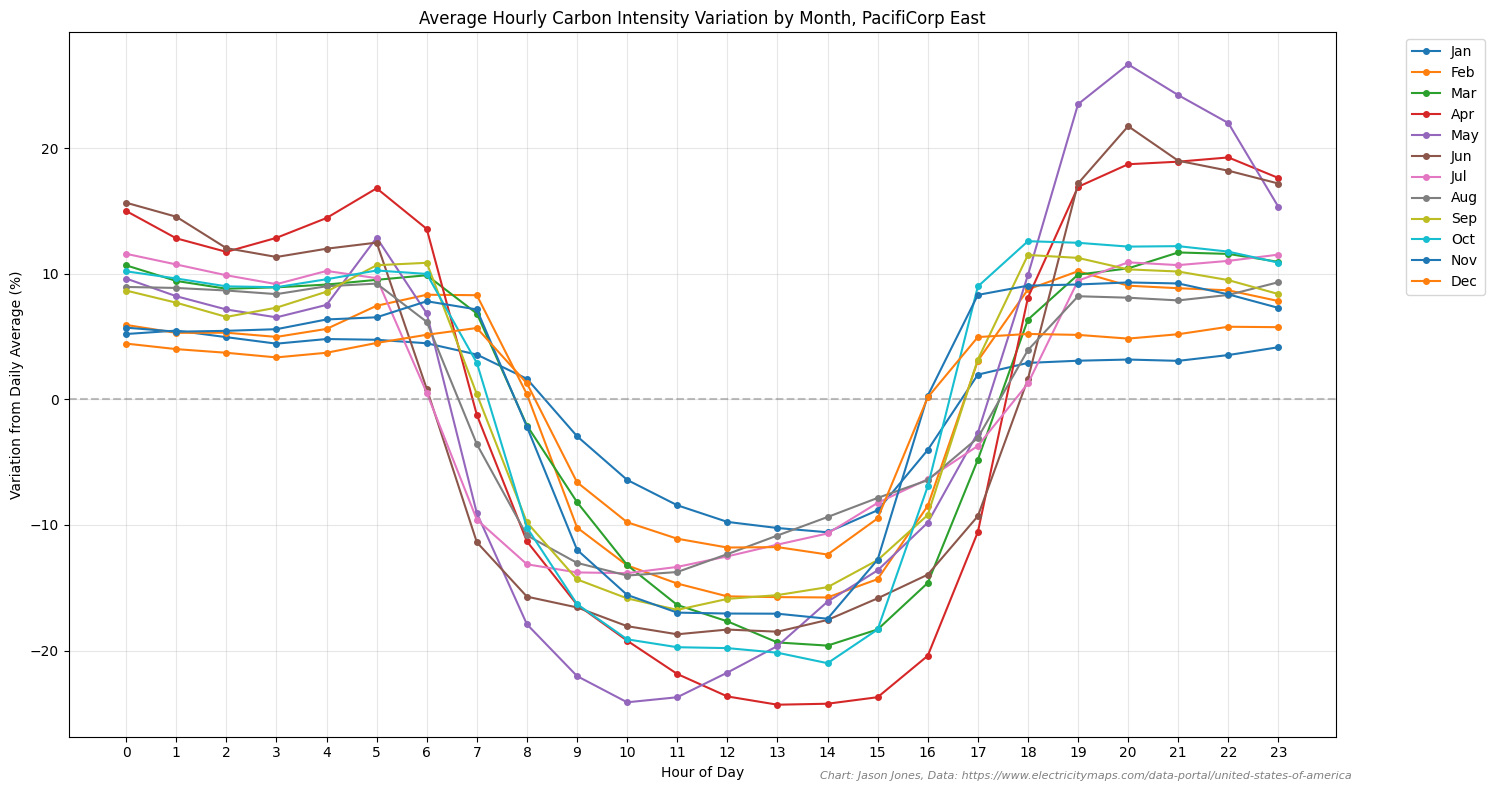


Hourly variations by month (percentage from daily average):
hour     0     1     2     3     4     5     6     7     8     9   ...    14  \
month                                                              ...         
Jan     5.2   5.5   5.0   4.4   4.8   4.7   4.5   3.6   1.6  -2.9  ... -10.6   
Feb     5.9   5.3   5.3   5.0   5.6   7.5   8.3   8.3   0.4 -10.2  ... -15.8   
Mar    10.7   9.4   8.8   8.9   9.1   9.5   9.9   6.8  -2.1  -8.2  ... -19.6   
Apr    15.0  12.8  11.7  12.9  14.4  16.8  13.6  -1.2 -11.3 -16.3  ... -24.2   
May     9.6   8.2   7.2   6.5   7.5  12.9   6.8  -9.1 -17.9 -22.0  ... -16.1   
Jun    15.7  14.5  12.0  11.3  12.0  12.5   0.8 -11.4 -15.7 -16.6  ... -17.6   
Jul    11.6  10.7   9.9   9.2  10.2   9.7   0.5  -9.6 -13.1 -13.8  ... -10.7   
Aug     9.0   8.9   8.7   8.4   9.0   9.2   6.2  -3.6 -10.8 -13.0  ...  -9.4   
Sep     8.7   7.7   6.6   7.3   8.6  10.7  10.9   0.4  -9.8 -14.3  ... -15.0   
Oct    10.2   9.6   9.0   8.9   9.6  10.3  10.0   2.9 -10.2

In [191]:
# Calculate daily averages for each month
daily_avgs = df.groupby(['month', 'date'])['Carbon Intensity gCO₂eq/kWh (LCA)'].mean()
# Broadcast daily averages back to hourly data
df['daily_avg'] = df.groupby(['date'])['Carbon Intensity gCO₂eq/kWh (LCA)'].transform('mean')
# Calculate percentage variation from daily average
df['percent_variation'] = ((df['Carbon Intensity gCO₂eq/kWh (LCA)'] - df['daily_avg']) / df['daily_avg']) * 100

# Calculate average hourly variations for each month
hourly_variations = df.groupby(['month', 'hour'])['percent_variation'].mean().unstack()

# Create the plot
plt.figure(figsize=(15, 8))

# Plot a line for each month
for month in hourly_variations.index:
    plt.plot(hourly_variations.columns, 
            hourly_variations.loc[month], 
            label=month_names[month],
            marker='o',
            markersize=4)

plt.title('Average Hourly Carbon Intensity Variation by Month, PacifiCorp East')
plt.xlabel('Hour of Day')
plt.ylabel('Variation from Daily Average (%)')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add source text at the bottom
plt.figtext(0.55, 0.02, 'Chart: Jason Jones, Data: https://www.electricitymaps.com/data-portal/united-states-of-america', 
           fontsize=8, style='italic', color='gray')

plt.tight_layout()

# Set x-axis ticks to show all 24 hours
plt.xticks(range(24))

# Add a horizontal line at y=0 to show the baseline
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.show()

# Rename the index for the printed table
hourly_variations.index = hourly_variations.index.map(month_names)
print("\nHourly variations by month (percentage from daily average):")
print(hourly_variations.round(1))